In [1]:
import os
import logging
import random
import gc
import time
import warnings
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from tensorflow.keras.utils import to_categorical

from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

# Check the TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.19.0
Num GPUs Available: 0


/Users/woojungkim/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class CFG:
    seed = 42
    debug = False
    print_freq = 100
    num_workers = 1

    # Set your project root directory
    PROJECT_ROOT_DIR = ".." # Adjust as needed
    
    OUTPUT_DIR = "../data/working"
    SPECTROGRAMS_DIR = OUTPUT_DIR + "/spectograms/"
    
    train_datadir = '../data/raw/train_audio'
    train_csv = '../data/raw/train.csv'
    taxonomy_csv = '../data/raw/taxonomy.csv'
    working_df_path = "../data/work_df_w_split_info.csv"

    working_df = SPECTROGRAMS_DIR + 'working_df.csv'


    # Parametric input dim (32, 64, or 256)
    # This would be used to also control the input path and shape (see below)
    input_dim = 32 # Default to 32
    
    # Derived paths and shapes
    @property
    def spectrogram_npy(self):
        return self.SPECTROGRAMS_DIR + f'birdclef2025_melspec_5sec_{self.input_dim}_{self.input_dim}.npy'
    
    @property  # Add this to make it dynamic
    def TARGET_SHAPE(self):
        return (self.input_dim, self.input_dim)
    
    in_channels = 1  # Single channel
    LOAD_DATA = True # Load data from precomputed spectrograms
    num_classes = 4  # 4 high-level classes

    epochs = 10
    batch_size = 128
    
    n_fold = 4
    selected_folds = [0,1,2,3]  # Use all folds by default

    lr = 5e-4 
    weight_decay = 1e-5
    min_lr = 1e-6
    

    # turning both on
    use_augmentation = True  # Toggle augmentation on/off
    use_oversampling = True  # Toggle oversampling on/off
    
    # Augmentation params
    aug_prob = 0.5 if use_augmentation else 0.0  # Probability of applying any augmentation
    mixup_alpha = 0.2 if use_augmentation else 0.0  # MixUp alpha (beta distribution)
    noise_std = 0.05  # Std dev for Gaussian noise
    max_time_shift = 0.2  # Fraction of time axis to shift (e.g., 20%)
    max_freq_shift = 0.2  # Fraction of freq axis to shift
    max_mask_time = 0.1  # Fraction of time axis to mask
    max_mask_freq = 0.1  # Fraction of freq axis to mask

    # Oversampling params: dict of {class_index: factor} to multiply minority samples
    # e.g., Aim to balance towards Aves (~5530 samples); set factor=0 for majority
    oversampling_factors = {0: 40,  # Amphibia (117 -> ~4680)
                            1: 0,   # Aves (majority, no oversampling)    
                            2: 150, # Insecta (31 -> ~4650)
                            3: 150, # Mammalia (35 -> ~5250)
                            }   
    
    # Derived model save name
    @property
    def model_save_name(self):
        suffix = ""
        if self.use_augmentation:
            suffix += "_aug"
        if self.use_oversampling:
            suffix += "_os"
        return f"base_model_{str(self.input_dim)}{suffix}.keras"

    def update_debug_settings(self):
        # Only run 1 fold and 6 epochs in debug mode, we will use this as a quick test
        if self.debug:
            self.epochs = 3
            self.selected_folds = [0]

cfg = CFG()

In [8]:
def add_noise(spec, std):
    noise = tf.random.normal(shape=tf.shape(spec), mean=0.0, stddev=std, dtype=tf.float32)
    return spec + noise

def time_shift(spec, shift_frac):
    shift = int(shift_frac * spec.shape[1])  # Time axis is dim 1
    return tf.roll(spec, shift=shift, axis=1)

def freq_shift(spec, shift_frac):
    shift = int(shift_frac * spec.shape[0])  # Freq axis is dim 0
    return tf.roll(spec, shift=shift, axis=0)

def mask_time(spec, mask_frac):
    mask_len = int(mask_frac * spec.shape[1])
    if mask_len == 0:
        return spec
    start = tf.random.uniform(shape=[], minval=0, maxval=spec.shape[1] - mask_len, dtype=tf.int32)
    mask = tf.zeros((spec.shape[0], mask_len, spec.shape[2]), dtype=spec.dtype)
    spec = tf.concat([spec[:, :start, :], mask, spec[:, start + mask_len:, :]], axis=1)
    return spec

def mask_freq(spec, mask_frac):
    mask_len = int(mask_frac * spec.shape[0])
    if mask_len == 0:
        return spec
    start = tf.random.uniform(shape=[], minval=0, maxval=spec.shape[0] - mask_len, dtype=tf.int32)
    mask = tf.zeros((mask_len, spec.shape[1], spec.shape[2]), dtype=spec.dtype)
    spec = tf.concat([spec[:start, :, :], mask, spec[start + mask_len:, :, :]], axis=0)
    return spec

def mixup(spec1, target1, spec2, target2, alpha):
    lam = np.random.beta(alpha, alpha)
    spec = lam * spec1 + (1 - lam) * spec2
    target = lam * target1 + (1 - lam) * target2
    return spec, target

def data_generator(df, cfg, spectrograms, is_train=True, yield_weight=True):
    """
    Generator function to yield spectrograms and targets for training or evaluation.
    If `is_train` is True, applies augmentations based on cfg settings.
    If `yield_weight` is True, yields sample weights based on class distribution.
    """
    rows = df.to_dict('records')  # List of dicts for easy access
    
    if cfg.use_oversampling and is_train:
        oversampled_rows = []
        for cls, factor in cfg.oversampling_factors.items():
            class_rows = [r for r in rows if r['y_species_encoded'] == cls]
            if factor == 0:  # For majority class (Aves), treat as multiplier=1 (no oversampling)
                multiplier = 1
            else:
                multiplier = factor
            oversampled_rows.extend(class_rows * multiplier)
        random.shuffle(oversampled_rows)  # Shuffle to randomize order
        rows = oversampled_rows

    for idx, row in enumerate(rows):
        samplename = row['samplename']
        spec = spectrograms.get(samplename, np.zeros((*cfg.TARGET_SHAPE, cfg.in_channels), dtype=np.float32))
        spec = np.expand_dims(spec, axis=-1)  # (H, W, 1)
        spec = tf.convert_to_tensor(spec, dtype=tf.float32)  # To TF tensor for ops
        
        target = to_categorical(row['y_species_encoded'], num_classes=cfg.num_classes)
        
        if is_train and cfg.use_augmentation and np.random.rand() < cfg.aug_prob:
            # Apply random augmentations
            if np.random.rand() < 0.5:  # 50% chance each
                spec = add_noise(spec, cfg.noise_std)
            if np.random.rand() < 0.5:
                spec = time_shift(spec, cfg.max_time_shift)
            if np.random.rand() < 0.5:
                spec = freq_shift(spec, cfg.max_freq_shift)
            if np.random.rand() < 0.5:
                spec = mask_time(spec, cfg.max_mask_time)
            if np.random.rand() < 0.5:
                spec = mask_freq(spec, cfg.max_mask_freq)
            
            # MixUp (requires another random sample)
            if cfg.mixup_alpha > 0 and np.random.rand() < 0.5:
                other_idx = np.random.randint(0, len(rows))
                other_row = rows[other_idx]
                other_spec = spectrograms.get(other_row['samplename'], np.zeros_like(spec))
                other_spec = tf.convert_to_tensor(np.expand_dims(other_spec, axis=-1), dtype=tf.float32)
                other_target = to_categorical(other_row['y_species_encoded'], num_classes=cfg.num_classes)
                spec, target = mixup(spec, target, other_spec, other_target, cfg.mixup_alpha)
        
        spec = spec.numpy()  # Back to numpy if needed for yield
        
        if yield_weight:
            sample_weight = class_weights[row['y_species_encoded']]  # Use original class for weight
            yield spec, target, sample_weight
        else:
            yield spec, target

In [9]:
print("\nLoading combined train data...")
full_df = pd.read_csv(cfg.working_df_path)

# Combine train and val as "combined train"
combined_train_val_df = full_df[full_df['split'].isin(['train', 'val'])].reset_index(drop=True)

combined_train_val_df.head()


Loading combined train data...


,primary_label,rating,filename,target,filepath,samplename,class,y_species_encoded,split
0,1139490,0.0,1139490/CSA36389.ogg,0,./data/raw/train_audio/1139490/CSA36389.ogg,1139490-CSA36389,Insecta,2,train
1,1192948,0.0,1192948/CSA36358.ogg,1,./data/raw/train_audio/1192948/CSA36358.ogg,1192948-CSA36358,Insecta,2,train
2,1192948,0.0,1192948/CSA36366.ogg,1,./data/raw/train_audio/1192948/CSA36366.ogg,1192948-CSA36366,Insecta,2,train
3,1192948,0.0,1192948/CSA36373.ogg,1,./data/raw/train_audio/1192948/CSA36373.ogg,1192948-CSA36373,Insecta,2,val
4,1194042,0.0,1194042/CSA18783.ogg,2,./data/raw/train_audio/1194042/CSA18783.ogg,1194042-CSA18783,Insecta,2,val


In [10]:
# Load pre-computed mel spectrograms
spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
print(f"Loaded {len(spectrograms)} pre-computed mel spectrograms")
print(f"Example spectrogram shape: {spectrograms['1139490-CSA36389'].shape}")

# This is a dict, the samplename '1139490-CSA36389' is the key
spectrograms['1139490-CSA36389']

Loaded 28564 pre-computed mel spectrograms
Example spectrogram shape: (32, 32)


array([[0.60927516, 0.82787275, 0.8543863 , ..., 0.5926887 , 0.8844918 ,
        0.7155297 ],
       [0.619291  , 0.89863867, 0.7358351 , ..., 0.60509133, 0.86708546,
        0.6459563 ],
       [0.53857917, 0.6364324 , 0.7601948 , ..., 0.54124737, 0.7848017 ,
        0.66509414],
       ...,
       [0.2903521 , 0.21302953, 0.23228   , ..., 0.24894655, 0.1931243 ,
        0.2143865 ],
       [0.2715999 , 0.22699611, 0.22744066, ..., 0.21395011, 0.23434846,
        0.22203825],
       [0.23533896, 0.2204537 , 0.20143878, ..., 0.23799029, 0.22495545,
        0.21065843]], dtype=float32)

In [14]:
# Custom class weights based on the distribution in the combined train/val set
@tf.keras.utils.register_keras_serializable()
class AddClsToken(tf.keras.layers.Layer):
    def __init__(self, projection_dim, **kwargs):
        super(AddClsToken, self).__init__(**kwargs)
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.cls_token = self.add_weight(
            shape=(1, 1, self.projection_dim),
            initializer="zeros",
            trainable=True,
            name="cls_token"
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls = tf.tile(self.cls_token, [batch_size, 1, 1])
        return tf.concat([cls, inputs], axis=1)

    def get_config(self):
        config = super(AddClsToken, self).get_config()
        config.update({"projection_dim": self.projection_dim})
        return config

@tf.keras.utils.register_keras_serializable()
def macro_f1_fn(y_true, y_pred):
    """Pure TensorFlow macro F1 implementation"""
    y_true_labels = tf.argmax(y_true, axis=-1)
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    
    num_classes = tf.shape(y_true)[-1]
    f1_scores = []
    
    for class_id in range(4):  # Use your num_classes=4
        true_class = tf.equal(y_true_labels, class_id)
        pred_class = tf.equal(y_pred_labels, class_id)
        
        tp = tf.reduce_sum(tf.cast(tf.logical_and(true_class, pred_class), tf.float32))
        fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(true_class), pred_class), tf.float32))
        fn = tf.reduce_sum(tf.cast(tf.logical_and(true_class, tf.logical_not(pred_class)), tf.float32))
        
        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        
        f1_scores.append(f1)
    
    return tf.reduce_mean(tf.stack(f1_scores))

In [15]:
def get_vit_model(cfg):
    input_shape = (*cfg.TARGET_SHAPE, cfg.in_channels)  # (32,32,1) or similar
    inputs = layers.Input(shape=input_shape)

    # Patch + Embed (conv stem)
    patch_size = 4
    projection_dim = 128  # Increased
    num_patches = (cfg.input_dim // patch_size) ** 2  # 64 for input_dim=32, etc.

    x = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    x = layers.Reshape((num_patches, projection_dim))(x)

    # Add class token using the custom layer
    x = AddClsToken(projection_dim=projection_dim)(x)

    # Positional embeddings (for num_patches + 1 positions)
    positions = tf.range(start=0, limit=num_patches + 1, delta=1)
    pos_embed = layers.Embedding(input_dim=num_patches + 1, output_dim=projection_dim)(positions)
    x = x + pos_embed

    # Transformer encoders
    num_blocks = 6  # Increased
    num_heads = 8   # Increased
    mlp_dim = 256   # Increased

    for _ in range(num_blocks):
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim // num_heads, dropout=0.2)(y, y)
        x = layers.Add()([x, y])

        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.Dense(mlp_dim, activation='gelu')(y)
        y = layers.Dropout(0.2)(y)
        y = layers.Dense(projection_dim)(y)
        x = layers.Add()([x, y])

    # Head: Use class token instead of GAP
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = x[:, 0, :]  # Extract cls_token
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(cfg.num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)

    return model

# # Chekc the model struture
# test_model = get_vit_model(cfg)

# test_model.compile(
#     optimizer = tf.keras.optimizers.AdamW(cfg.lr, weight_decay=cfg.weight_decay),
#     loss      = tf.keras.losses.CategoricalFocalCrossentropy(gamma=2.0, alpha=0.25),
#     metrics   = [
#         "accuracy",
#         tf.keras.metrics.AUC(name="auc"),
#         tf.keras.metrics.AUC(curve="PR", name="pr_auc"),
#         macro_f1_fn,                    # your custom metric
#     ],
# )

# # Get the model summary
# test_model.summary()

# # Clean up
# del test_model
# gc.collect()

In [16]:
# Sanity check: Print class counts across full dataset
class_counts = combined_train_val_df['y_species_encoded'].value_counts().sort_index()
print("Full dataset class distribution (0: Amphibia, 1: Aves, 2: Insecta, 3: Mammalia):")
print(class_counts)
print(f"Imbalance ratio: Aves / Total = {class_counts[1] / class_counts.sum():.2%}")

# Create class mapping dictionary
class_mapping_dict = {
    0: 'Amphibia',
    1: 'Aves',
    2: 'Insecta',
    3: 'Mammalia'
}

# Sanity check 2: Inspect a batch from the generator
gen = data_generator(combined_train_val_df[combined_train_val_df['split'] == 'train'], cfg, spectrograms, is_train=True, yield_weight=False)
batch_specs, batch_labels = next(gen)  # Get one item (since generator is per-sample)
print("\nExample batch label (one-hot):", batch_labels)
print("Class order matches Dense layer: [Amphibia, Aves, Insecta, Mammalia]")

# Create class weights for imbalanced dataset
classes = np.unique(combined_train_val_df['y_species_encoded'])
labels = combined_train_val_df['y_species_encoded'].values
class_weights = compute_class_weight('balanced', classes=classes, y=labels)
class_weights_dict = dict(zip(classes, class_weights))
print("Computed class weights:", class_weights_dict)


Full dataset class distribution (0: Amphibia, 1: Aves, 2: Insecta, 3: Mammalia):
y_species_encoded
0      466
1    22118
2      124
3      143
Name: count, dtype: int64
Imbalance ratio: Aves / Total = 96.79%

Example batch label (one-hot): [1. 0. 0. 0.]
Class order matches Dense layer: [Amphibia, Aves, Insecta, Mammalia]
Computed class weights: {np.int64(0): np.float64(12.25912017167382), np.int64(1): np.float64(0.25828510715254543), np.int64(2): np.float64(46.07056451612903), np.int64(3): np.float64(39.9493006993007)}


In [18]:
def make_ds(df, is_train, with_weight=True):
    sig = (
        tf.TensorSpec((*cfg.TARGET_SHAPE, cfg.in_channels), tf.float32),
        tf.TensorSpec((cfg.num_classes,), tf.float32),
    )
    if with_weight:
        sig += (tf.TensorSpec((), tf.float32),)

    gen = lambda: data_generator(df, cfg, spectrograms,
                                 is_train=is_train, yield_weight=with_weight)

    return tf.data.Dataset.from_generator(gen, output_signature=sig) \
             .shuffle(10_000 if is_train else 1) \
             .prefetch(tf.data.AUTOTUNE)   


In [19]:
class_weights_dict

{np.int64(0): np.float64(12.25912017167382),
 np.int64(1): np.float64(0.25828510715254543),
 np.int64(2): np.float64(46.07056451612903),
 np.int64(3): np.float64(39.9493006993007)}

In [20]:
cfg.model_save_name

'base_model_32_aug_os.keras'

In [21]:
# Simple 80/20 stratified split
train_df, val_df = train_test_split(
    combined_train_val_df, 
    test_size=0.2, 
    stratify=combined_train_val_df['y_species_encoded'],
    random_state=cfg.seed
)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")


# 1) build TRAIN / VAL datasets *without* sample weights
train_ds = make_ds(train_df, is_train=True,  with_weight=False)
val_ds   = make_ds(val_df,   is_train=False, with_weight=False)

# 2) (optional) keep a larger shuffle + batch here if you like
train_ds = train_ds.shuffle(buffer_size=len(train_df))\
                   .batch(cfg.batch_size)\
                   .prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)

model = get_vit_model(cfg)

model.compile(
    optimizer = tf.keras.optimizers.AdamW(cfg.lr, weight_decay=cfg.weight_decay),
    loss      = tf.keras.losses.CategoricalFocalCrossentropy(gamma=2.0, alpha=0.25),
    metrics   = [
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.AUC(curve="PR", name="pr_auc"),
        macro_f1_fn,                    # your custom metric
    ],
)

# Callbacks
model_checkpoint = callbacks.ModelCheckpoint(
    "best_model.keras", 
    monitor='val_macro_f1', 
    mode='max', 
    save_best_only=True,
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_macro_f1',
    mode='max',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_macro_f1',
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=cfg.min_lr,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs          = cfg.epochs,
    class_weight    = class_weights_dict,
    callbacks       = [model_checkpoint, early_stopping],
)

# Save the model
model.save(cfg.model_save_name)


Train size: 18280, Val size: 4571
Epoch 1/10


2025-07-29 12:55:01.207981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 5580 of 18280
2025-07-29 12:55:09.262021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


    505/Unknown 811s 2s/step - accuracy: 0.2613 - auc: 0.4946 - loss: 3.6913 - macro_f1_fn: 0.1801 - pr_auc: 0.2985

2025-07-29 13:08:12.890170: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-07-29 13:08:33.772356: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


505/505 ━━━━━━━━━━━━━━━━━━━━ 832s 2s/step - accuracy: 0.2614 - auc: 0.4946 - loss: 3.6899 - macro_f1_fn: 0.1801 - pr_auc: 0.2986 - val_accuracy: 0.0096 - val_auc: 0.0227 - val_loss: 0.9711 - val_macro_f1_fn: 0.0147 - val_pr_auc: 0.1379
Epoch 2/10


2025-07-29 13:08:44.067162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 2702 of 18280
2025-07-29 13:08:55.062821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4205 - auc: 0.5998 - loss: 2.0131 - macro_f1_fn: 0.3094 - pr_auc: 0.4517

2025-07-29 13:23:20.087439: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


505/505 ━━━━━━━━━━━━━━━━━━━━ 886s 2s/step - accuracy: 0.4205 - auc: 0.5999 - loss: 2.0127 - macro_f1_fn: 0.3095 - pr_auc: 0.4518 - val_accuracy: 0.0144 - val_auc: 0.0893 - val_loss: 0.8697 - val_macro_f1_fn: 0.0245 - val_pr_auc: 0.1444
Epoch 3/10


2025-07-29 13:23:30.445551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 4327 of 18280
2025-07-29 13:23:40.162143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


505/505 ━━━━━━━━━━━━━━━━━━━━ 911s 2s/step - accuracy: 0.5270 - auc: 0.6700 - loss: 1.3961 - macro_f1_fn: 0.4404 - pr_auc: 0.5653 - val_accuracy: 0.0217 - val_auc: 0.2111 - val_loss: 0.7017 - val_macro_f1_fn: 0.0297 - val_pr_auc: 0.1596
Epoch 4/10


2025-07-29 13:38:41.134047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 4663 of 18280
2025-07-29 13:38:52.375710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5875 - auc: 0.7095 - loss: 1.0841 - macro_f1_fn: 0.5048 - pr_auc: 0.6220

2025-07-29 13:52:39.149563: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


505/505 ━━━━━━━━━━━━━━━━━━━━ 848s 2s/step - accuracy: 0.5875 - auc: 0.7095 - loss: 1.0841 - macro_f1_fn: 0.5049 - pr_auc: 0.6220 - val_accuracy: 0.0208 - val_auc: 0.2472 - val_loss: 0.6172 - val_macro_f1_fn: 0.0312 - val_pr_auc: 0.1649
Epoch 5/10


2025-07-29 13:52:49.445229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 5188 of 18280
2025-07-29 13:52:57.485887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


505/505 ━━━━━━━━━━━━━━━━━━━━ 738s 1s/step - accuracy: 0.6211 - auc: 0.7415 - loss: 0.9169 - macro_f1_fn: 0.5367 - pr_auc: 0.6577 - val_accuracy: 0.0219 - val_auc: 0.1362 - val_loss: 0.6426 - val_macro_f1_fn: 0.0294 - val_pr_auc: 0.1492
Epoch 6/10


2025-07-29 14:05:07.760066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 5441 of 18280
2025-07-29 14:05:16.042267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


505/505 ━━━━━━━━━━━━━━━━━━━━ 762s 1s/step - accuracy: 0.6377 - auc: 0.7509 - loss: 0.8596 - macro_f1_fn: 0.5507 - pr_auc: 0.6766 - val_accuracy: 0.0225 - val_auc: 0.2522 - val_loss: 0.5824 - val_macro_f1_fn: 0.0300 - val_pr_auc: 0.1652
Epoch 7/10


2025-07-29 14:17:50.180822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 5579 of 18280
2025-07-29 14:17:59.693430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


505/505 ━━━━━━━━━━━━━━━━━━━━ 794s 2s/step - accuracy: 0.6448 - auc: 0.7619 - loss: 0.7967 - macro_f1_fn: 0.5563 - pr_auc: 0.6844 - val_accuracy: 0.0243 - val_auc: 0.2944 - val_loss: 0.5428 - val_macro_f1_fn: 0.0313 - val_pr_auc: 0.1726
Epoch 8/10


2025-07-29 14:31:04.492589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 3288 of 18280
2025-07-29 14:31:15.908306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6524 - auc: 0.7706 - loss: 0.7491 - macro_f1_fn: 0.5650 - pr_auc: 0.6997

2025-07-29 14:43:08.467279: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


505/505 ━━━━━━━━━━━━━━━━━━━━ 734s 1s/step - accuracy: 0.6524 - auc: 0.7706 - loss: 0.7491 - macro_f1_fn: 0.5650 - pr_auc: 0.6997 - val_accuracy: 0.0225 - val_auc: 0.3250 - val_loss: 0.5194 - val_macro_f1_fn: 0.0305 - val_pr_auc: 0.1793
Epoch 9/10


2025-07-29 14:43:19.070627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 5317 of 18280
2025-07-29 14:43:27.869153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


505/505 ━━━━━━━━━━━━━━━━━━━━ 750s 1s/step - accuracy: 0.6569 - auc: 0.7794 - loss: 0.6891 - macro_f1_fn: 0.5695 - pr_auc: 0.7024 - val_accuracy: 0.0230 - val_auc: 0.3112 - val_loss: 0.4939 - val_macro_f1_fn: 0.0292 - val_pr_auc: 0.1765
Epoch 10/10


2025-07-29 14:55:48.662318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 6415 of 18280
2025-07-29 14:55:56.018737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


505/505 ━━━━━━━━━━━━━━━━━━━━ 771s 1s/step - accuracy: 0.6586 - auc: 0.7838 - loss: 0.6955 - macro_f1_fn: 0.5714 - pr_auc: 0.7068 - val_accuracy: 0.0210 - val_auc: 0.2930 - val_loss: 0.5247 - val_macro_f1_fn: 0.0282 - val_pr_auc: 0.1721


In [24]:
def plot_test_evaluation(y_true, y_pred, class_mapping=None):
    """
    Plot confusion matrix and per-class metrics for test evaluation
    
    Parameters:
    -----------
    y_true: One-hot encoded true labels
    y_pred: Predicted probabilities
    class_mapping: dict mapping index to class name, e.g. {0: 'Amphibia', 1: 'Aves', ...}
    """
    # Default mapping if none provided
    if class_mapping is None:
        class_mapping = {i: f'Class_{i}' for i in range(y_true.shape[1])}
    
    # Get class names in order
    num_classes = len(class_mapping)
    class_names = [class_mapping[i] for i in range(num_classes)]
    
    # Convert one-hot to class indices
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[0].figure.colorbar(im, ax=axes[0])
    axes[0].set(xticks=np.arange(cm.shape[1]),
                yticks=np.arange(cm.shape[0]),
                xticklabels=class_names, 
                yticklabels=class_names,
                title='Confusion Matrix',
                ylabel='True label',
                xlabel='Predicted label')
    
    # Rotate tick labels
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    
    # Plot 2: Per-class probabilities distribution
    for idx, class_name in enumerate(class_names):
        axes[1].hist(y_pred[:, idx], bins=30, alpha=0.5, label=class_name)
    axes[1].set_xlabel('Predicted Probability')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distribution of Predicted Probabilities by Class')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))



def evaluate_on_test(model, cfg, spectrograms, test_df):
    # Create test dataset (no weights)
    test_ds = tf.data.Dataset.from_generator(
        lambda: data_generator(test_df, cfg, spectrograms, is_train=False, yield_weight=False),
        output_signature=(
            tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
            tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32)
        )
    )
    test_ds = test_ds.batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)
    
    # Ground truth labels
    y_true = np.array([to_categorical(row['y_species_encoded'], num_classes=cfg.num_classes) for _, row in test_df.iterrows()])
    
    # Ensemble predictions from all folds
    y_pred_avg = np.zeros((len(test_df), cfg.num_classes))
    

    y_pred = model.predict(test_ds, verbose=1)
    y_pred_avg += y_pred / len(cfg.selected_folds)
    tf.keras.backend.clear_session()
    gc.collect()

    
    # Compute metrics
    test_loss = losses.CategoricalCrossentropy()(y_true, y_pred_avg).numpy()
    test_auc = metrics.AUC(multi_label=False)(y_true, y_pred_avg).numpy()
    test_acc = metrics.CategoricalAccuracy()(y_true, y_pred_avg).numpy()
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Return predictions for visualization
    return y_true, y_pred_avg

Test size: 5713
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 544ms/step

Test Loss: 2.4829
Test AUC: 0.2956
Test Accuracy: 0.0200


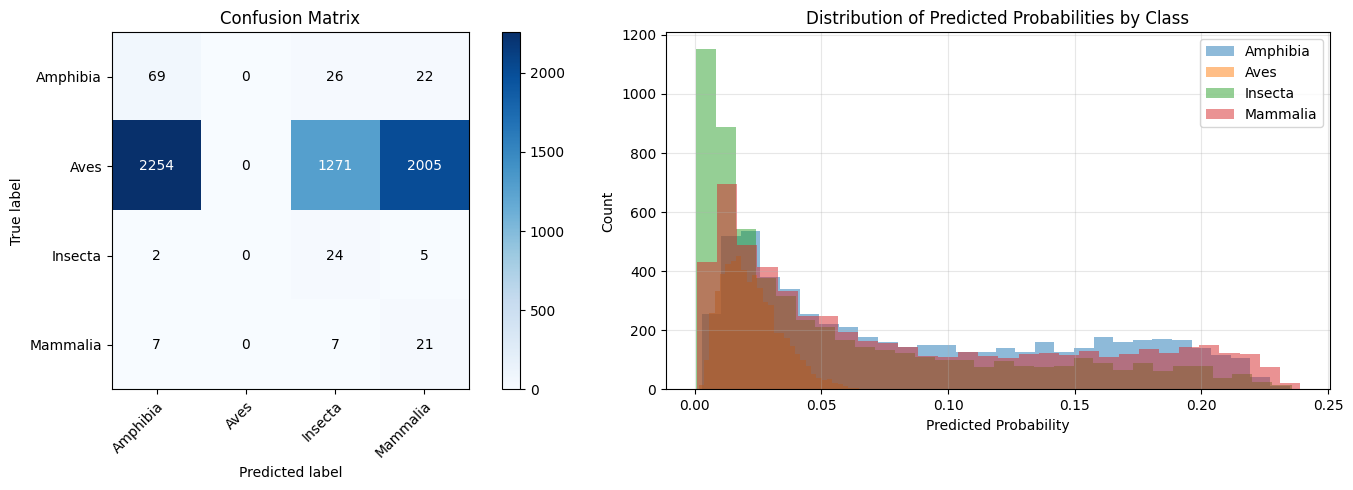


Classification Report:
              precision    recall  f1-score   support

    Amphibia       0.03      0.59      0.06       117
        Aves       0.00      0.00      0.00      5530
     Insecta       0.02      0.77      0.04        31
    Mammalia       0.01      0.60      0.02        35

    accuracy                           0.02      5713
   macro avg       0.01      0.49      0.03      5713
weighted avg       0.00      0.02      0.00      5713



In [25]:
# Run evaluation
test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
print(f"Test size: {len(test_df)}")

y_true, y_pred = evaluate_on_test(model, cfg, spectrograms, test_df)

# Plot with dictionary
plot_test_evaluation(y_true, y_pred, class_mapping=class_mapping_dict)


In [26]:
custom_objs = {
    'AddClsToken': AddClsToken,
    'macro_f1_fn': macro_f1_fn
}

test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
print(f"Test size: {len(test_df)}")

Test size: 5713


Evaluating on test set...
Loading model for input_dim=32...
Loaded 28564 pre-computed mel spectrograms for 32x32
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 807ms/step

Test Loss: 2.4829
Test AUC: 0.2956
Test Accuracy: 0.0200


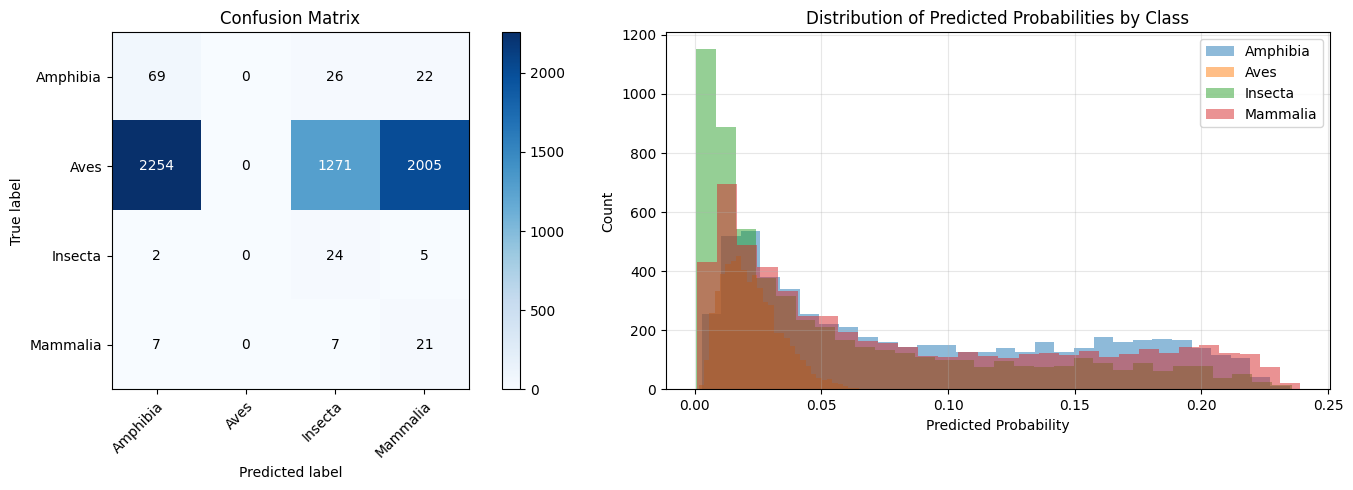


Classification Report:
              precision    recall  f1-score   support

    Amphibia       0.03      0.59      0.06       117
        Aves       0.00      0.00      0.00      5530
     Insecta       0.02      0.77      0.04        31
    Mammalia       0.01      0.60      0.02        35

    accuracy                           0.02      5713
   macro avg       0.01      0.49      0.03      5713
weighted avg       0.00      0.02      0.00      5713



In [30]:
# Loop over available models
print("Evaluating on test set...")
for i in [32]:
    print(f"Loading model for input_dim={i}...")
    cfg.input_dim = i  # Dynamically update

    # Reload spectrograms for the new input_dim
    spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
    print(f"Loaded {len(spectrograms)} pre-computed mel spectrograms for {i}x{i}")

    loaded_model = tf.keras.models.load_model(
        f"base_model_{str(i)}_aug_os.keras",
        custom_objects=custom_objs
    )

    y_true, y_pred = evaluate_on_test(loaded_model, cfg, spectrograms, test_df)

    # Plot with dictionary
    plot_test_evaluation(y_true, y_pred, class_mapping=class_mapping_dict)

Loading model for 32
Loading model with suffix _aug...
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step

Test Loss: 1.3071
Test AUC: 0.6760
Test Accuracy: 0.1225


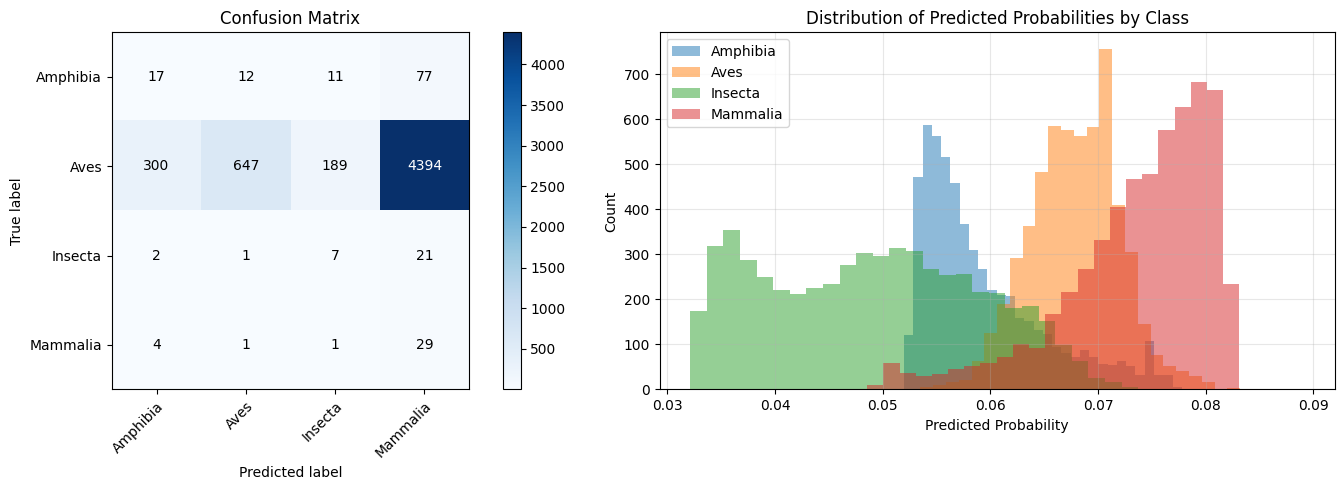


Classification Report:
              precision    recall  f1-score   support

    Amphibia       0.05      0.15      0.08       117
        Aves       0.98      0.12      0.21      5530
     Insecta       0.03      0.23      0.06        31
    Mammalia       0.01      0.83      0.01        35

    accuracy                           0.12      5713
   macro avg       0.27      0.33      0.09      5713
weighted avg       0.95      0.12      0.20      5713

Loading model for 32
Loading model with suffix _os...
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step

Test Loss: 1.3980
Test AUC: 0.7107
Test Accuracy: 0.2346


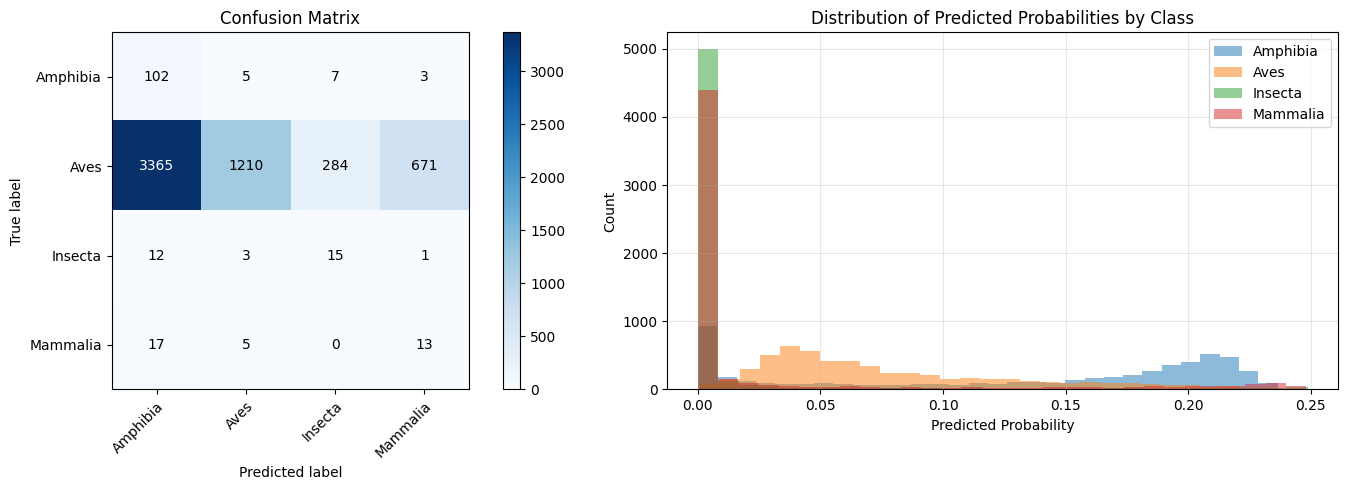


Classification Report:
              precision    recall  f1-score   support

    Amphibia       0.03      0.87      0.06       117
        Aves       0.99      0.22      0.36      5530
     Insecta       0.05      0.48      0.09        31
    Mammalia       0.02      0.37      0.04        35

    accuracy                           0.23      5713
   macro avg       0.27      0.49      0.13      5713
weighted avg       0.96      0.23      0.35      5713



In [21]:
cfg.input_dim = 32  # Reset to default for suffix loop

for s in ['_aug', '_os']:

    print(f"Loading model for {cfg.input_dim}")
    spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
    
    print(f"Loading model with suffix {s}...")
    loaded_model = tf.keras.models.load_model(
        f"base_model_{str(cfg.input_dim)}{s}.keras",
        custom_objects=custom_objs
    )

    y_true, y_pred = evaluate_on_test(loaded_model, cfg, spectrograms, test_df)

    # Plot with dictionary
    plot_test_evaluation(y_true, y_pred, class_mapping=class_mapping_dict)